# Quantum state preparation without coherent arithmetic

This notebook implements a quantum state preparation circuit based on _Quantum State Preparation Without Coherent Arithmetic_ ([arXiv:2210.14892](https://arxiv.org/pdf/2210.14892)), as part of “Implementation Challenge” by Classiq. 
 Specifically, we will construct a Gaussian state preparation circuit from [Classiq’s MIT iQuHack 2025 challenge](https://github.com/iQuHACK/2025-Classiq/blob/main/classiq_iQuHack_2025_final.ipynb) using the approach outlined in this paper.

$$|{x_0}\rangle_N = |0\rangle_N \rightarrow \sum_x {G(x)} |{x}\rangle_N$$

## Algorithm Overview

The algorithm leverages Quantum Eigenvalue Transformation (QET) technique to encode a function into a quantum state. 
The key idea is to approximate the desired function using polynomial approximations and implement these polynomials as quantum circuits.

#### General workflow
- The algorithm starts by defining a function $f(x)$ (in this case, a Gaussian function) to be encoded into the quantum state.
- It constructs a block-encoding circuit ($U_{\text{sin}}$) that initializes the input state.
- Using QET, the function $f(x)$ is applied to the input state via a circuit ($U_f$) that encodes the polynomial approximation of $f(x)$.
- Finally, amplitude amplification ($U_{\text{amp}}$) is applied to increase the probability of measuring the desired state.

#### Benefits
- Scalability: The algorithm avoids the need for coherent arithmetic, making it more efficient for amplitude encoding. It requires only a fixed number of ancillary qubits (at most 4) regardless of the function's complexity.
- Flexibility: It supports encoding various functions, such as polynomial or Fourier series approximations, and is applicable to a wide range of continuous functions.
- Resource Efficiency: By leveraging QET, the algorithm minimizes the number of non-Clifford gates and logical qubits while avoiding the use of amplitude oracles.

#### Complexity
- The complexity of the algorithm depends on the degree of the polynomial approximation used for `f(x)`. Higher-degree polynomials provide better approximations but require more quantum gates.
- Specifically, the non-Clifford gate complexity of the QET-based approach is approximately:
            $$ O\left(\frac{n \cdot d}{F}\right), $$
where:
    - $n$: Number of qubits representing the input state.
    - $d$: Degree of the polynomial approximation.
    - $F$: L2-norm filling-fraction of the polynomial approximation.

This complexity indicates that the number of non-Clifford gates scales linearly with the number of qubits $n$ and the polynomial degree $d$.
For detailed analysis, please refer to the paper.

## Implementation

To implement amplitude encoding without coherent arithmetic, we construct the following three components, as described in Figure 1 of the paper:
- $U_{\text{sin}}$: Block encoding of the initial values.
- $U_f$: Function application via Quantum Eigenvalue Transformation (QET).
- $U_{\text{amp}}$: Amplitude amplification to increase the probability of the target state.

For each component, we follow Section 2 of the paper. In constructing $U_f$, we determine the QET rotation angles using [pyqsp](https://github.com/ichuang/pyqsp) or other techniques. For evaluation, we verify correctness via state-vector simulation for small cases and perform resource estimation.

For Gaussian state preparation, we set `f(x)` to be the Gaussian function described in the[ MIT iQuHack 2025 challenge notebook](https://github.com/iQuHACK/2025-Classiq/blob/main/classiq_iQuHack_2025_final.ipynb).

In [1]:
# import all necessary modules
from typing import Dict

import numpy as np
from matplotlib import pyplot as plt
from pyqsp import angle_sequence, response
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from pyqsp.poly import PolyTaylorSeries
from scipy.integrate import quad
from scipy.stats import norm

import classiq
from classiq import *
from classiq.execution import *

print(classiq.__version__)

0.79.0


## 0. Set Parameters for Gaussian State Preparation

We define the parameters for the Gaussian state, including the truncation value, decay rate, number of qubits, and the Gaussian function.

In [2]:
# Parameters for Gaussian amplitude
TRUNCATION_VALUE = 2  # truncation value of the Gaussian
MIN_X = -TRUNCATION_VALUE  # min x
MAX_X = TRUNCATION_VALUE  # max x
EXP_RATE = 1  # decay rate of the Gaussian
F = lambda x: np.exp(-EXP_RATE * (x**2))  # Gaussian function

# Resolution of input x
NUM_QUBITS = 8

## 1. Define $U_{\text{sin}}$ circuit

To prepare the target state, we first need to define $U_{\text{sin}}$ such that:

$$
U_{\text{sin}} |{x}\rangle_n |{0}\rangle_a = |{x}\rangle_n (\sin(x/N)|{0}\rangle_a + \cos(x/N)|{1}\rangle_a)
$$

where $n$ is the number of qubits used to represent the state, $a$ is the ancillary qubit, and $N=2^n$ is the number of possible states. 

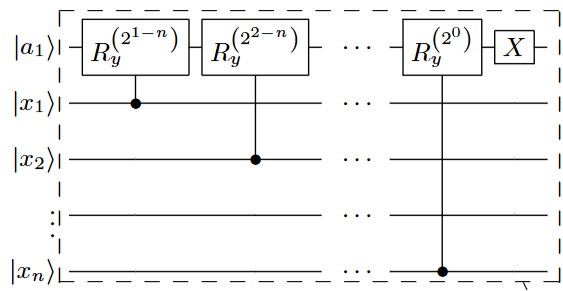

The circuit above shows $U_{\text{sin}}$ (Fig. 1a in the paper). It is implemented as follows:

In [3]:
@qfunc
def u_sin(x: QArray[QBit], a: QBit) -> None:
    repeat(
        count=x.len,
        iteration=lambda i: CRY(theta=2 ** (-x.len + i + 1), ctrl=x[i], target=a),
    )
    X(a)

## 2. Define $U_{\tilde{f}}$ circuit

Then by combining the $U_{\text{sin}}$ circuit with the QSVT technique, we can define the circuit $U_{\tilde{f}}$ that applies the given function $f$ to the state $|{x}\rangle_n$ such that
$$
U_{\tilde{f}} |{+}\rangle^{\otimes{n}}|{000}\rangle_a = c_{0} |{\Psi_{\tilde{f}}}\rangle|{000}\rangle_a + ...
$$
where $\tilde{f}$ is the approximation of the function $f$, $|{\Psi_{\tilde{f}}}\rangle$ is the state after applying the function, and $c_{0}$ is the coefficient of the desired state with $|{000}\rangle_a$.

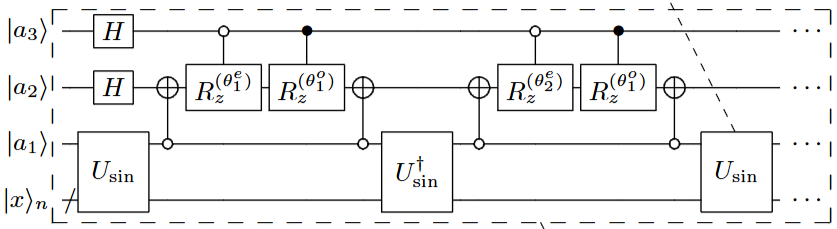

The circuit above shows $U_{\tilde{f}}$ (Fig. 1b in the paper). 
We will implement this circuit using the QSVT technique, which allows us to apply the function $f$ to the input block encoding circuit $U_{\text{sin}}$.

As shown in S2 in the paper, the function we seek to implement using QSVT is the scaled version of 
$$
h(y) = f((b-a)\arcsin(y)+a)
$$
over the domain $y \in [0, \sin(1)]$.
This is defined as `POLY_FUNC` in the code below.

In [4]:
def h(f, a, b):
    """
    Eq. (3) in https://arxiv.org/pdf/2210.14892
    """
    return lambda y: f((b - a) * np.arcsin(y) + a)


def h_hat(h, h_max):
    """
    Eq. (4) in https://arxiv.org/pdf/2210.14892

    The scaled version of the function h(y).
    """
    return lambda y: h(y) / h_max


# Scaled function definition following the paper
H_FUNC = h(f=F, a=MIN_X, b=MAX_X)
POLY_FUNC = h_hat(h=H_FUNC, h_max=F(0))  # maximum value of the Gaussian is at x=0

Since `POLY_FUNC` does not have a defnite parity, we should use QSVT for mixed parity version.
To do this, we first split the function into even and odd parts.

In [5]:
# Even and odd part of the function for the mixed parity QSVT
POLY_EVEN = lambda x: (POLY_FUNC(x) + POLY_FUNC(-x))
POLY_ODD = lambda x: (POLY_FUNC(x) - POLY_FUNC(-x))

# Parameter of the QSVT
POLY_DEGREE = 25
POLY_MAX_SCALE = 1

Then we can find the phase angles of even and odd parts for QSVT using the `pyqsp` library.
The angles are then used to construct the QSVT circuit.

Here we use `POLY_DEGREE+3` and `POLY_DEGREE+2` for even and odd parts respectively, because it is sufficient to approximate the function (see Appendix A).

In [6]:
def adjust_qsvt_conventions(phases: np.ndarray, degree: int) -> np.ndarray:
    phases = np.array(phases)
    phases = phases - np.pi / 2
    phases[0] = phases[0] + np.pi / 4
    phases[-1] = phases[-1] + np.pi / 2 + (2 * degree - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    return -2 * phases


def compute_qsvt_phases(poly, degree, max_scale):
    chebyshev_poly = PolyTaylorSeries().taylor_series(
        func=poly,
        degree=degree,
        max_scale=max_scale,
        chebyshev_basis=True,
        cheb_samples=degree,
    )
    phases = QuantumSignalProcessingPhases(
        chebyshev_poly, signal_operator="Wx", method="laurent", measurement="x"
    )
    return adjust_qsvt_conventions(phases, degree).tolist()


# Compute the phase angles for the even and odd parts of the function
phiset_even = compute_qsvt_phases(POLY_EVEN, POLY_DEGREE + 3, POLY_MAX_SCALE)
phiset_odd = compute_qsvt_phases(POLY_ODD, POLY_DEGREE + 2, POLY_MAX_SCALE)

# Match the length of the phase angles for even and odd parts by adding dummy value
if len(phiset_even) - 1 == len(phiset_odd):
    phiset_odd = np.append(phiset_odd, [0])
assert len(phiset_even) == len(phiset_odd)

[PolyTaylorSeries] (Cheb) max 1.0000002010996418 is at 0.47942527263309914: normalizing
[PolyTaylorSeries] (Cheb) average error = 2.3092589728477082e-07 in the domain [-1, 1] using degree 28
[PolyTaylorSeries] (Cheb) max 1.0000011023789412 is at -0.47942595340330507: normalizing
[PolyTaylorSeries] (Cheb) average error = 6.79904715625726e-07 in the domain [-1, 1] using degree 27


Now we are ready to construct $U_{\tilde{f}}$ circuit.
The code below implements the $U_{\tilde{f}}$ circuit using `qsvt_lcu` function from classiq library, which allows us to apply the mixed parity QSVT circuit to the input block encoding circuit $U_{\text{sin}}$.

In [7]:
@qfunc
def projector_cnot(reg: QNum, aux: QBit) -> None:
    aux ^= reg == 0


@qfunc
def u_f(
    x: QNum,
    a1: QBit,
    a2_qsvt: QBit,
    a3_qsvt: QBit,
):
    """u_{f^{\tilde}} circuit for state preparation using QET (more generally, QSVT)

    Args:
        x (QNum): main qubits for the input x
        a1 (QBit): auxiliary qubit for block encoding of u_sin
        a2_qsvt (QBit): auxiliary qubit for QSVT
        a3_qsvt (QBit): auxiliary qubit for mixed parity (NOTE: It is unnecessary if f^{\tilde} has definite parity)
    """

    # Apply mixed parity QSVT
    full_reg = QArray()
    within_apply(
        lambda: [bind([a1, x], full_reg), H(a3_qsvt)],
        lambda: qsvt_lcu(
            phase_seq_even=phiset_odd,
            phase_seq_odd=phiset_even,
            proj_cnot_1=lambda reg, aux: projector_cnot(
                reg[0], aux
            ),  # reg==0 representing "from state". If the state is "from state", then mark aux qubit as |1>
            proj_cnot_2=lambda reg, aux: projector_cnot(
                reg[0], aux
            ),  # reg==0 representing "to state". If the state is "to state", then mark aux qubit as |1>
            u=lambda reg: u_sin(
                reg[1 : reg.len], reg[0]
            ),  # reg[1:reg.len] is "x" and reg[0] is "a"
            qvar=full_reg,
            aux=a2_qsvt,
            lcu=a3_qsvt,
        ),
    )
    H(a3_qsvt)

## 3. Define $U_{\text{amp}}$ circuit

The final step is to define $U_\text{amp}$ by attaching the amplitude amplification technique to the $U_{\tilde{f}}$ circuit.
$U_\text{amp}$ amplifies $c_{0}$, the coefficient of the target state $|{\Psi_{\tilde{f}}}\rangle$, to increase the probability of measuring the target state and discard the other states as follows:

$$
c_{0} |{\Psi_{\tilde{f}}}\rangle{000}_a + c_{1}|{\cdot}\rangle|{001}\rangle_a + ... \rightarrow |{\Psi_{\tilde{f}}}\rangle|{000}\rangle_a
$$

To do this, we can use `exact_amplitude_amplification` from Classiq library, which allows us to apply the amplitude amplification technique to the input circuit $U_{\tilde{f}}$.
It requires the exact amplitude $c_0$ so we precalculate it using `get_gaussian_amplitude` function as follows (see Appendix B for the details of how we calculate the amplitude).

In [8]:
def squared_gaussian_integral(a, b, mean=0.0, sigma=1.0):
    """
    Computes the integral of f(x)^2 from a to b,
    where f(x) is the Gaussian PDF with mean=0 and std=sigma.
    """
    prefactor = 1 / (2 * np.pi * sigma**2)

    def integrand(x):
        return prefactor * np.exp(-((x - mean) ** 2) / sigma**2)

    result, _ = quad(integrand, a, b)
    return result


def gaussian_max(a, b, mean=0.0, sigma=1.0):
    x1 = a
    x2 = b
    x3 = 0
    if a < mean and b > mean:
        x3 = mean
    else:
        x3 = a
    X = np.array([x1, x2, x3])
    return max(norm.pdf(X, mean, sigma))


def get_gaussian_amplitude(a, b, mean=0.0, sigma=1.0, factor=1.45):
    Numerator = np.sqrt(squared_gaussian_integral(a, b, mean, sigma))
    Denominator = np.sqrt((b - a)) * gaussian_max(a, b, mean, sigma)
    return (Numerator / Denominator) * (factor / 2.0)


amp = get_gaussian_amplitude(MIN_X, MAX_X, mean=0.0, sigma=1.0 / np.sqrt(2 * EXP_RATE))
print("amplitude before amplification: ", amp)

amplitude before amplification:  0.40581138324751564


Now we are ready to construct $U_{\text{amp}}$ circuit.
The code below implements the $U_{\text{amp}}$ circuit using `exact_amplitude_amplification` function, where
- `state_prep` is the circuit that prepares the initial state before amplitude amplification.
- `reflect_about_zero` is the circuit that marks the target state $|{\Psi_{\tilde{f}}}\rangle$ to be amplified.

In [9]:
class MyQStruct(QStruct):
    x: QNum[NUM_QUBITS, UNSIGNED, NUM_QUBITS]  # Representation of the input x
    a1: QBit  # Auxiliary qubit for the u_sin circuit
    a2: QBit  # Auxiliary qubit for the QSVT circuit
    a3: QBit  # Auxiliary qubit for mixed parity QSVT (NOTE: It is unnecessary if f^{\tilde} has definite parity)


@qfunc
def state_prep(reg: MyQStruct):
    hadamard_transform(reg.x)
    u_f(reg.x, reg.a1, reg.a2, reg.a3)


@qfunc
def u_amp(
    x: QNum,
    a1: QBit,
    a2: QBit,
    a3: QBit,
):
    """Amplitude amplification circuit for state preparation using QET (more generally, QSVT)

    Args:
        x (QNum): Representation of the input x
        a1 (QBit): Auxiliary qubit for the u_sin circuit
        a2 (QBit): Auxiliary qubit for the QSVT circuit
        a3 (QBit): Auxiliary qubit for mixed parity QSVT (NOTE: It is unnecessary if f^{\tilde} has definite parity)
    #"""
    reg = QArray()
    within_apply(
        lambda: bind([x, a1, a2, a3], reg),
        lambda: exact_amplitude_amplification(
            amplitude=amp,
            oracle=lambda _reg: reflect_about_zero(
                _reg[x.size : x.size + 3]
            ),  # Mark if the state is good state. Auxiliary qubits are |0> => good state
            space_transform=lambda _reg: state_prep(_reg),
            packed_qvars=reg,
        ),
    )

## Check the result

We simulate the circuit and check if the Gaussian state is prepared correctly.

In [10]:
@qfunc
def main(
    x: Output[QNum],
    a1: Output[QBit],
    a2_qsvt: Output[QBit],
    a3_qsvt_parity: Output[QBit],
):
    allocate(NUM_QUBITS, x)
    allocate(1, a1)
    allocate(1, a2_qsvt)
    allocate(1, a3_qsvt_parity)
    u_amp(x, a1, a2_qsvt, a3_qsvt_parity)


qmod = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
    preferences=Preferences(timeout_seconds=1800),
)
write_qmod(qmod, "stateprep_guassian_using_qsvt")
qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result_value()

Quantum program link: https://platform.classiq.io/circuit/2x2veBshskNXsagcdihN5rNj95G?login=True&version=0.79.0


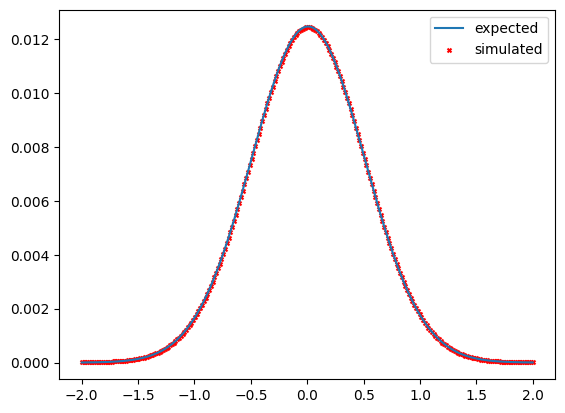

Mean Squared Error (MSE): 1.2671536694173466e-10
{'depth': 6690, 'width': 14, 'cx_count': 3618}


In [11]:
from numpy import zeros_like


def get_metrics(qprog):
    """
    Extract circuit metrics from a quantum program.

    Parameters:
        qprog: The quantum program object.

    Returns:
        dict: A dictionary containing the circuit metrics:
              - "depth": Circuit depth.
              - "width": Circuit width (number of qubits used).
              - "cx_count": Number of CX gates (returns 0 if none are present).
    """
    # Generate the optimized quantum circuit
    circuit = QuantumProgram.from_qprog(qprog)

    # Extract metrics
    metrics = {
        "depth": circuit.transpiled_circuit.depth,
        "width": circuit.data.width,
        "cx_count": circuit.transpiled_circuit.count_ops.get(
            "cx", 0
        ),  # Default to 0 if 'cx' not found
    }

    return metrics


def normalize(list):
    return list / np.sum(list)


def amp_to_prob(amplitude):
    return (np.linalg.norm(amplitude)) ** 2


def parse_qsvt_results(result) -> Dict:
    amps: Dict = {x: [] for x in range(2**NUM_QUBITS)}

    for parsed_state in result.parsed_state_vector:
        if (
            parsed_state["a1"] == 0
            and parsed_state["a2_qsvt"] == 0
            and parsed_state["a3_qsvt_parity"] == 0
            and np.linalg.norm(parsed_state.amplitude) > 1e-10
        ):
            amps[parsed_state["x"]].append(parsed_state.amplitude)
    simulated_prob = [amp_to_prob(amp) for amp in amps.values()]
    return simulated_prob


x = np.linspace(MIN_X, MAX_X, 2**NUM_QUBITS)
simulated = parse_qsvt_results(result)
expected = normalize(
    [
        amp_to_prob(F(((MAX_X - MIN_X) * x / 2**NUM_QUBITS) + MIN_X))
        for x in range(2**NUM_QUBITS)
    ]
)
# Assert that the probabilities sum to 1
assert np.isclose(
    sum(simulated), 1.0, atol=1e-2
), "Simulated probabilities do not sum to 1. {}".format(sum(simulated))
assert np.isclose(
    sum(expected), 1.0, atol=1e-2
), "Expected probabilities do not sum to 1. {}".format(sum(expected))
plt.plot(x, expected, label="expected")
plt.scatter(x, simulated, label="simulated", marker="x", color="red", s=8)
plt.legend()
plt.show()

# Calculate MSE between simulated and expected probabilities
mse = np.mean((np.array(simulated) - np.array(expected)) ** 2)
print("Mean Squared Error (MSE):", mse)

# Print circuit metrics
print(get_metrics(qprog))

# Appendix A: Compute QSVT Phase Angles

This section details the process of computing QSVT phase angles for even and odd polynomials using the `pyqsp` library.

### Finding phase angles for the even polynomial

Get Chebychev coefficients for the even parts of the polynomial

In [12]:
poly_even = PolyTaylorSeries().taylor_series(
    func=POLY_EVEN,
    degree=POLY_DEGREE + 3,
    max_scale=POLY_MAX_SCALE,
    chebyshev_basis=True,
    cheb_samples=(POLY_DEGREE + 3),
)

[PolyTaylorSeries] (Cheb) max 1.0000002010996418 is at 0.47942527263309914: normalizing
[PolyTaylorSeries] (Cheb) average error = 2.3092589728477082e-07 in the domain [-1, 1] using degree 28


Compute phase angles

In [13]:
(phiset_even) = angle_sequence.QuantumSignalProcessingPhases(
    poly_even, signal_operator="Wx", method="laurent", measurement="x"
)
print(phiset_even)
print("len(phiset_even):", len(phiset_even))

[-1.5707638052650055, -1.739611231665883e-05, 3.4974273703358705e-05, 6.19730257889195e-06, -0.0006122100531238406, 0.002279801990280106, -0.0014437937270845858, -0.013232527724066134, 0.04175526063108914, -0.030699079504687754, -0.09369728174206715, 0.24876290976132331, -0.1643884044848707, -0.2162590324006175, 0.4550058564651067, -0.21625903240061262, -0.16438840448487468, 0.24876290976132331, -0.09369728174206471, -0.030699079504689974, 0.04175526063108914, -0.013232527724065468, -0.0014437937270850298, 0.002279801990280106, -0.0006122100531236185, 6.197302579113995e-06, 3.4974273702914616e-05, -1.739611231621474e-05, 3.252152989130508e-05]
len(phiset_even): 29


Plot

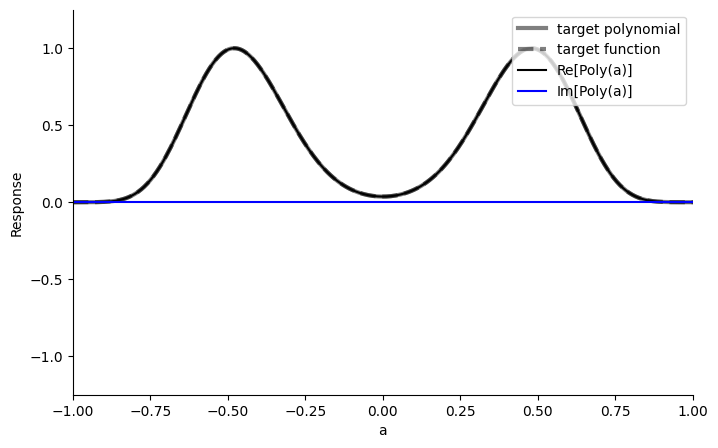

In [14]:
response.PlotQSPResponse(
    np.append(phiset_even, []),
    pcoefs=poly_even,
    target=lambda x: POLY_MAX_SCALE * POLY_EVEN(x),
)

### Finding phase angles for the odd polynomial

Get Chebychev coefficients for the odd parts of the polynomial

In [15]:
poly_odd = PolyTaylorSeries().taylor_series(
    func=POLY_ODD,
    degree=POLY_DEGREE + 2,
    max_scale=POLY_MAX_SCALE,
    chebyshev_basis=True,
    cheb_samples=(POLY_DEGREE + 2),
)

[PolyTaylorSeries] (Cheb) max 1.0000011023789412 is at -0.47942595340330507: normalizing
[PolyTaylorSeries] (Cheb) average error = 6.79904715625726e-07 in the domain [-1, 1] using degree 27


Compute phase angles

In [16]:
(phiset_odd) = angle_sequence.QuantumSignalProcessingPhases(
    poly_odd, signal_operator="Wx", method="laurent", measurement="x"
)
print(phiset_odd)
print("len(phiset_odd):", len(phiset_odd))

[-1.5707673839990588, -9.221004307891079e-06, 7.761735495503963e-05, -0.0003334565336157169, 0.00016066073603537845, 0.003241736774113324, -0.011197678748920081, 0.007958341102741295, 0.04045713298617204, -0.11729095324548622, 0.08448725166742288, 0.16323661955244617, -0.39046421472405046, 0.21967173426394626, 0.2196717342639496, -0.390464214724052, 0.16323661955244395, 0.0844872516674271, -0.117290953245488, 0.04045713298617093, 0.007958341102743072, -0.011197678748920525, 0.003241736774112658, 0.0001606607360356005, -0.0003334565336157169, 7.761735495503963e-05, -9.221004307669034e-06, 2.8942795837538782e-05]
len(phiset_odd): 28


Plot

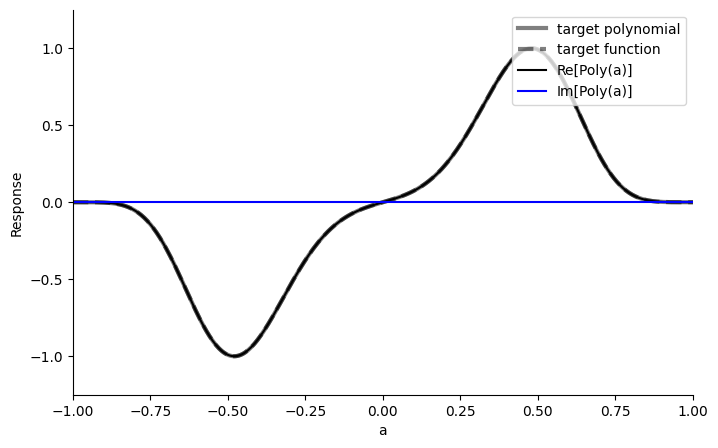

In [17]:
response.PlotQSPResponse(
    np.append(phiset_odd, []),
    pcoefs=poly_odd,
    target=lambda x: POLY_MAX_SCALE * POLY_ODD(x),
)

## Appendix B: Amplitude Calibration for Exact Amplitude Amplification

This section show how we find the amplitude for the exact amplitude amplification. 
It contains the numerical analysis for calibrating the amplitude, including Newton's method and linear regression.

### Motivation

In our implementation, we observed that the formula for the target amplitude—used prior to applying `exact_amplitude_amplification`—did not produce the expected results.
To address this, we performed a numerical analysis using Newton’s method and found that **multiplying the amplitude from the paper by a factor of 1.45** led to improved agreement with the intended state.

It documents this investigation and provides supporting numerical evidence.
This difference may be due to implementation-specific details or implicit assumptions in the paper that differ from our setting.

In [18]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

We observed that the amplitude that we calculated referring to the paper gave us inadequate values. 

We wanted to find the true amplitude by investigating the amplified probability when the wrong amplitude was given.

Let the given amplitude be $a$, and the true amplitude to be $\alpha$ and the resulting probability to be $P(a,\alpha)$.

The code applies the oracle for $k = \lceil \frac{\pi}{4 \arcsin (a)} -\frac{1}{2} \rceil$ times. 

Also since it is an exact amplitude amplification, it adjusts amplitude by $\frac{\sin (\theta)}{a}$ where $\theta = \frac{\pi}{4k+2}$.

That makes the amplitude to be $\sin \varphi = \frac{\alpha \sin \theta}{a} $

To wrap up, when we put amplitude as $a$ in the exact amplitude amplification function, 

the amplified probability of the given state will be

\begin{align}
    P(a,\alpha) & = \sin^2 ( (2k+1) \varphi )\\
    & = \sin^2 [ (2k+1) \cdot \arcsin ( \frac{\alpha}{a} \sin \frac{\pi}{4k+2} )  ]
\end{align}


Plotting this function gives

![image.png](attachment/image1.png){: width="30%" height="30%"}

If we run the code for wrong amplitude, it will give some value $X$.

Solving $P(a,\alpha)-X=0$ for fixed $a$ will give at most two possible $X$.

Thus, solving this for several $a$ values and averaging the close ones gives the 

reasonable guess for the real amplitude, $\alpha$. (We deliberately used wrong $a$ as an input)

We applied Newton's method for solving this numerically.

(When we put several values of $a$ for the same setting, we can observe that it usually gave two answers

for the real amplitude. And one of the two values seems to be shown up for every cases and the other value

didn's showed such correlation. Thus, we could conclude that the recurring value for the different $a$ values

to be the exact amplitude and averaged them.)

The plot for the estimated amplitude and the calculated amplitude showed clear linear relation.

![image.png](attachment/image2.png)

Therefore, we adjusted the calculation by multiplying 1.450 for the calculated value to get the 

adequate amplitdue for the exact amplitude amplification.

In [19]:
def find_k(a):
    k = math.ceil(np.pi / (4 * np.arcsin(a)) - 0.5)
    return k


def find_mismatch(a, alpha):
    k = find_k(a)
    theta = np.pi / (4 * k + 2)
    varphi = np.arcsin(alpha * np.sin(theta) / a)

    amplitude = np.sin((2 * k + 1) * varphi)
    return amplitude

In [20]:
# Step 2: Parameters
a = 0.75
X = np.sqrt(0.73497)  # target mismatch value
# X=0

In [21]:
# Function for P(x) and its derivative, denoted as f(x) and df(x) respectively


# function for computing P(x)
def f(x):
    return find_mismatch(a, x) - X


# function for computing P'(x). Since required precision is 1e-10, I used h=1e-12, which is smaller then the given precision.
def df(x):
    h = 1e-6
    return (f(x + h) - f(x - h)) / (2 * h)

In [22]:
# Newton's method


def newtonMethod(x):
    dx = f(x) / df(x)
    return x - dx


# Newtons' method solution starting from x0, with precision denoted as error
def findSol(x0, error):
    indicator = True

    while indicator:
        x = newtonMethod(x0)
        condition1 = abs(f(x) < error)
        condition2 = abs(x - x0) < error
        x0 = x
        indicator = not (condition1 and condition2)
    return x0


# Finding the roots by Newton's method for the given list of inital points. (Initial guess for the roots)
def roots_of_f(x0_List, error):
    roots = []
    for i in range(len(x0_List)):
        solution = findSol(x0_List[i], error)
        roots.append(solution)
    return roots

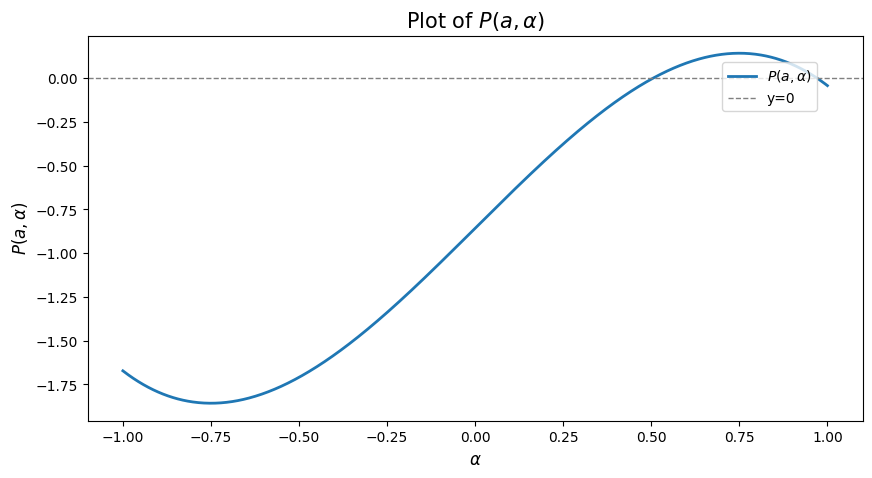

In [23]:
# 1-1) Plotting the P(x)

# The plot shows that the good guess for the roots are

# 0.04, 0.15, 0.37, 0.61, 0.83, 0.95


# Create x values from 0 to 1
x = np.linspace(-1, 1, 1000)
y = f(x)

# Plot f(x)
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="$P(a,\\alpha)$", linewidth=2)

# Add horizontal line at y=0
plt.axhline(0, color="gray", linestyle="--", linewidth=1, label="y=0")

# Labels and title
plt.title("Plot of $P(a, \\alpha)$", fontsize=15)
plt.xlabel("$\\alpha$", fontsize=12)
plt.ylabel("$P(a, \\alpha)$", fontsize=12)
# plt.grid(True)
plt.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95))

# Show the plot
plt.show()

In [24]:
# 1-2) Finding the roots of P(x)=0 for x=0 to x=1. The initial guessing points are from 1-1)
x_i = [0.0, 0.9]
error = 1e-10

roots = np.array(roots_of_f(x_i, error))
print("Roots from Newton's Method")
print(roots)
print()
print("Function values for calcualted roots.")
print("They are very close to 0.")
print(f(roots))

Roots from Newton's Method
[0.50494613 0.97074893]

Function values for calcualted roots.
They are very close to 0.
[ 0.00000000e+00 -1.11022302e-16]


Followings are the data for estimated/calculated value of amplitude for varying range with $\text{EXP}\_\text{RATE} = 1 $

Linear Regression shows good fitting 

If we allow intercept, we get slope of $1.539$ ($R^2 = 0.9928$)

If we don't allow intercept, we get slope of $1.450$ ($R^2 = 0.9895$)

Since their $R^2$ value had only $0.003$ difference, we used

linear fitting without intercept.

We originally suspected missing factor of $1.5$ but as we put more data, it became $1.450$, far from $1.5$

In [25]:
# Step 1: Input data
calculated = np.array(
    [
        0.2798699195,
        0.3227396325,
        0.3394745017,
        0.3280870938,
        0.2991333939,
        0.3364705575,
        0.3566061132,
        0.2763977805,
    ]
)
estimated = np.array(
    [
        0.4036581867,
        0.46719464,
        0.48612144,
        0.4767588633,
        0.43207591,
        0.4901969,
        0.52633533,
        0.3973483175,
    ]
)

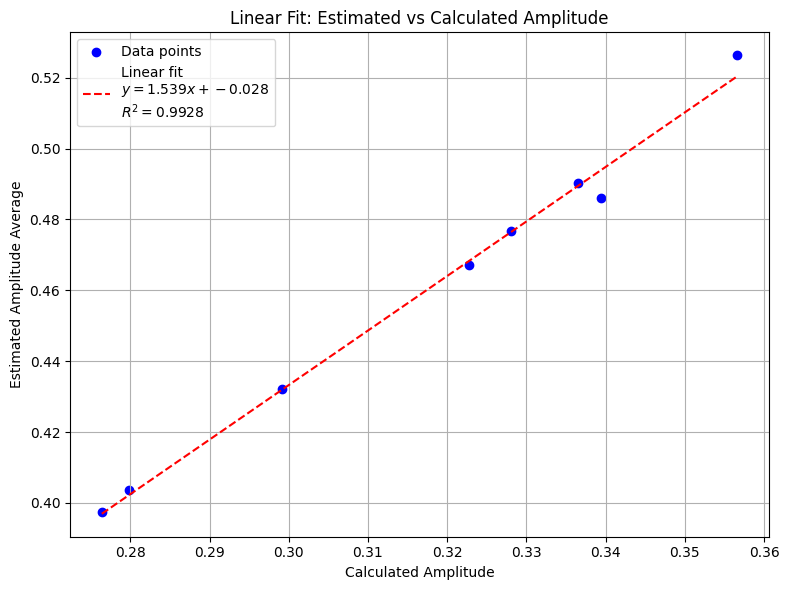

In [26]:
# Step 2: Linear regression
slope, intercept, r_value, p_value, std_err = linregress(calculated, estimated)
line_x = np.linspace(min(calculated), max(calculated), 100)
line_y = slope * line_x + intercept

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(calculated, estimated, color="blue", label="Data points")
plt.plot(
    line_x,
    line_y,
    color="red",
    linestyle="--",
    label=f"Linear fit\n$y={slope:.3f}x + {intercept:.3f}$\n$R^2={r_value**2:.4f}$",
)
plt.xlabel("Calculated Amplitude")
plt.ylabel("Estimated Amplitude Average")
plt.title("Linear Fit: Estimated vs Calculated Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def r_squared_given_slope(x, y, fixed_slope):
    """
    Calculates R^2 for the best-fit line y = fixed_slope * x + intercept,
    where the slope is fixed and intercept is optimized.
    """
    # Step 1: Compute optimal intercept for fixed slope
    intercept = np.mean(y - fixed_slope * x)

    # Step 2: Predict y using this line
    y_pred = fixed_slope * x + intercept

    # Step 3: Compute R^2
    ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared, intercept


# Example: Evaluate R^2 for a fixed slope (e.g., 1.3)
fixed_slope = np.sqrt(2)
r2, optimal_intercept = r_squared_given_slope(calculated, estimated, fixed_slope)

print(f"Fixed slope: {fixed_slope}")
print(f"Optimal intercept: {optimal_intercept:.6f}")
print(f"R^2 value: {r2:.6f}")

Fixed slope: 1.4142135623730951
Optimal intercept: 0.011164
R^2 value: 0.986302


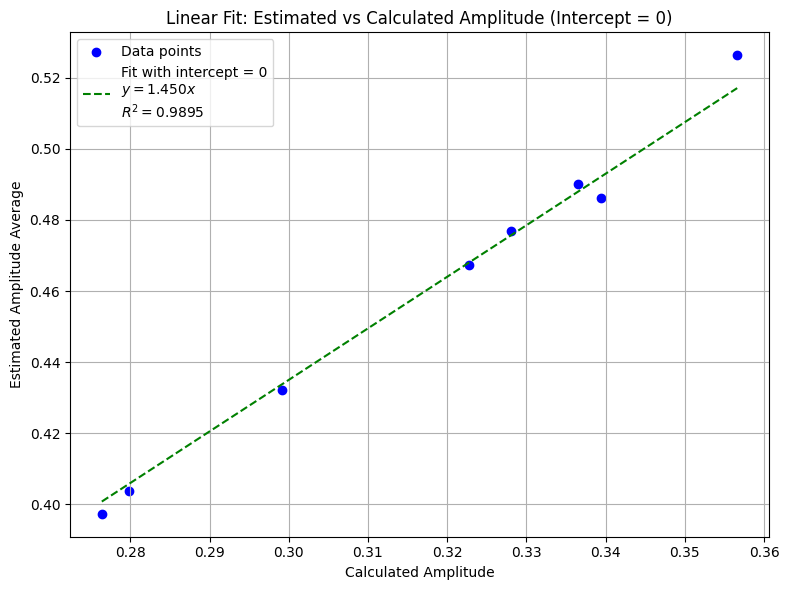

In [28]:
# Step 2: Linear regression with intercept = 0
slope_0 = np.sum(calculated * estimated) / np.sum(calculated**2)
y_pred_0 = slope_0 * calculated
ss_res_0 = np.sum((estimated - y_pred_0) ** 2)
ss_tot = np.sum((estimated - np.mean(estimated)) ** 2)
r2_0 = 1 - ss_res_0 / ss_tot

# Step 3: Plot
line_x = np.linspace(min(calculated), max(calculated), 100)
line_y = slope_0 * line_x

plt.figure(figsize=(8, 6))
plt.scatter(calculated, estimated, color="blue", label="Data points")
plt.plot(
    line_x,
    line_y,
    color="green",
    linestyle="--",
    label=f"Fit with intercept = 0\n$y = {slope_0:.3f}x$\n$R^2 = {r2_0:.4f}$",
)
plt.xlabel("Calculated Amplitude")
plt.ylabel("Estimated Amplitude Average")
plt.title("Linear Fit: Estimated vs Calculated Amplitude (Intercept = 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
def r_squared_fixed_slope_intercept_zero(x, y, fixed_slope):
    """
    Calculates R^2 for the line y = fixed_slope * x,
    where slope is fixed and intercept is 0.
    """
    # Step 1: Predict y using fixed slope and intercept = 0
    y_pred = fixed_slope * x

    # Step 2: Compute R^2
    ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


fixed_slope = 1.5  # Example slope

r2 = r_squared_fixed_slope_intercept_zero(calculated, estimated, fixed_slope)
print(f"R² for slope = {fixed_slope}, intercept = 0: {r2:.6f}")

R² for slope = 1.5, intercept = 0: 0.846960
